#

### Step 3: Titiler-CMR Compatibility Check

In the previous step, we created a csv file that includes the collection ids and variable names for each collection. In this step, we will run a compatibility check to see if the variables are compatible with Titiler-CMR.

```python

In [1]:
import ast
import random
from datetime import datetime as dt, UTC, timedelta
import pandas as pd
from datacube_benchmark.titiler import (
    DatasetParams,
    check_titiler_cmr_compatibility
)


#df_read = pd.read_csv("cmr_collections_netcdf4_updated.csv")
df_read = pd.read_csv("cmr_collections_netcdf4_updated_saved_all.csv")


df_read = df_read.dropna(subset=["variables"]).copy()
df_read.head()


/home/jovyan/datacube-guide_2/datacube-guide/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,concept_id,short_name,entry_title,provider_id,begin_time,end_time,west,south,east,north,links,variables,status,error,scheme
0,C2105092163-LAADS,VNP03IMG,VIIRS/NPP Imagery Resolution Terrain Corrected...,LAADS,2012-01-19T00:00:00.000Z,NaN,-180.0,-90.0,180.0,90.0,https://data.laadsdaac.earthdatacloud.nasa.gov...,[],ok,NaN,https
1,C2105091501-LAADS,VNP02IMG,VIIRS/NPP Imagery Resolution 6-Min L1B Swath 3...,LAADS,2012-01-19T00:00:00.000Z,NaN,-180.0,-90.0,180.0,90.0,https://data.laadsdaac.earthdatacloud.nasa.gov...,[],ok,NaN,https
2,C1562021084-LAADS,CLDMSK_L2_VIIRS_SNPP,VIIRS/Suomi-NPP Cloud Mask 6-Min Swath 750 m,LAADS,2012-03-01T00:00:00.000Z,NaN,-180.0,-90.0,180.0,90.0,https://data.laadsdaac.earthdatacloud.nasa.gov...,[],ok,NaN,https
3,C1964798938-LAADS,CLDMSK_L2_VIIRS_NOAA20,VIIRS/NOAA20 Cloud Mask and Spectral Test Resu...,LAADS,2012-03-01T00:00:00.000Z,NaN,-180.0,-90.0,180.0,90.0,https://data.laadsdaac.earthdatacloud.nasa.gov...,[],ok,NaN,https
4,C1593392869-LAADS,CLDMSK_L2_MODIS_Aqua,MODIS/Aqua Cloud Mask 5-Min Swath 1000 m,LAADS,2002-07-04T00:00:00.000Z,NaN,-180.0,-90.0,180.0,90.0,https://data.laadsdaac.earthdatacloud.nasa.gov...,[],ok,NaN,https


In [ ]:
import re

def extract_status_code(error):
    if pd.isna(error) or error is None:
        return None
    match = re.search(r'(?<!\d)([1-5]\d{2})(?!\d)', str(error))
    if match:
        return match.group(1)
    return None

endpoint = "https://staging.openveda.cloud/api/titiler-cmr"
for col in ["compatible", "compat_error", "status_code"]:
    if col not in df_read.columns:
        df_read[col] = None

for actual_idx, row in df_read.iterrows():
    concept_id = row["concept_id"]
    begin = row["begin_time"]
    end = row["end_time"] if pd.notna(row["end_time"]) else (dt.now(UTC) - timedelta(days=1)).strftime("%Y-%m-%dT%H:%M:%SZ")
    variable_list = row["variables"]
    
    variable = None
    if isinstance(variable_list, str):
        try:
            variable_list = ast.literal_eval(variable_list)
        except Exception as e:
            print(f"⚠️ [{actual_idx}] Failed to parse variable list: {e}")
            df_read.at[actual_idx, "compatible"] = False
            df_read.at[actual_idx, "compat_error"] = f"Failed to parse variable list: {e}"
            df_read.at[actual_idx, "status_code"] = extract_status_code(str(e))
            continue
    elif isinstance(variable_list, float):
        variable_list = []
    
    # -- pick random variable
    if isinstance(variable_list, list) and variable_list:
        variable = random.choice(variable_list)
    
    print(f"\n🔍 [{actual_idx}] Checking: {concept_id}")
    print(f"🕒 [{actual_idx}] Time: {begin} → {end}")
    print(f"📦 [{actual_idx}] Variable list: {variable_list}, Selected Variable: {variable}")
    
    if variable is None:
        print(f"⏭️ [{actual_idx}] Skipping {concept_id} - no variable found")
        df_read.at[actual_idx, "compatible"] = False
        df_read.at[actual_idx, "compat_error"] = "No variable found"
        df_read.at[actual_idx, "status_code"] = None
        continue
    
    # Pick a random week
    try:
        dt_begin = dt.fromisoformat(begin.replace("Z", "+00:00"))
        dt_end = dt.fromisoformat(end.replace("Z", "+00:00"))
        delta_days = (dt_end - dt_begin).days
        
        if delta_days < 7:
            datetime_range = f"{dt_begin.strftime('%Y-%m-%dT%H:%M:%SZ')}/{dt_end.strftime('%Y-%m-%dT%H:%M:%SZ')}"
            print(f"📆 [{actual_idx}] Time range < 7 days, using full range: {datetime_range}")
            continue
        
        offset_days = random.randint(0, delta_days - 7)
        week_start = dt_begin + timedelta(days=offset_days)
        week_end = week_start + timedelta(days=6)
        datetime_range = f"{week_start.strftime('%Y-%m-%dT%H:%M:%SZ')}/{week_end.strftime('%Y-%m-%dT%H:%M:%SZ')}"
        print(f"📆 [{actual_idx}] Using week range: {datetime_range}")
        
    except Exception as time_err:
        print(f"❌ [{actual_idx}] Failed to select week: {time_err}")
        df_read.at[actual_idx, "compatible"] = False
        df_read.at[actual_idx, "compat_error"] = str(time_err)
        df_read.at[actual_idx, "status_code"] = extract_status_code(str(time_err))
        continue
    
    ds_xarray = DatasetParams(
        concept_id=concept_id,
        backend="xarray",
        datetime_range=datetime_range,
        variable=variable,
        step="P1D",
        temporal_mode="point",
    )
    
    try:
        compat = await check_titiler_cmr_compatibility(
            endpoint=endpoint,
            dataset=ds_xarray,
            timeout_s=500,
            bounds_fraction=0.00001
        )
        compatibility_value = compat.get("compatibility")
        is_compatible = compatibility_value == "compatible"
        error_msg = compat.get("error")
        
        df_read.at[actual_idx, "compatible"] = is_compatible
        df_read.at[actual_idx, "compat_error"] = error_msg
        df_read.at[actual_idx, "status_code"] = extract_status_code(str(error_msg)) if error_msg else None
        print(f"✅ [{actual_idx}] Result: {compatibility_value}")
        if error_msg:
            print(f"⚠️ [{actual_idx}] Error from response: {error_msg}")
    
    except Exception as compat_err:
        print(f"❌ [{actual_idx}] Compatibility check failed: {compat_err}")
        df_read.at[actual_idx, "compatible"] = False
        df_read.at[actual_idx, "compat_error"] = str(compat_err)
        df_read.at[actual_idx, "status_code"] = extract_status_code(str(compat_err))

print(f"\n✅ Completed checking {len(df_read)} collections")
print(f"Compatible: {df_read['compatible'].sum()}")


🔍 [0] Checking: C2105092163-LAADS
🕒 [0] Time: 2012-01-19T00:00:00.000Z → 2025-10-05T10:22:37Z
📦 [0] Variable list: [], Selected Variable: None
⏭️ [0] Skipping C2105092163-LAADS - no variable found

🔍 [1] Checking: C2105091501-LAADS
🕒 [1] Time: 2012-01-19T00:00:00.000Z → 2025-10-05T10:22:37Z
📦 [1] Variable list: [], Selected Variable: None
⏭️ [1] Skipping C2105091501-LAADS - no variable found

🔍 [2] Checking: C1562021084-LAADS
🕒 [2] Time: 2012-03-01T00:00:00.000Z → 2025-10-05T10:22:37Z
📦 [2] Variable list: [], Selected Variable: None
⏭️ [2] Skipping C1562021084-LAADS - no variable found

🔍 [3] Checking: C1964798938-LAADS
🕒 [3] Time: 2012-03-01T00:00:00.000Z → 2025-10-05T10:22:37Z
📦 [3] Variable list: [], Selected Variable: None
⏭️ [3] Skipping C1964798938-LAADS - no variable found

🔍 [4] Checking: C1593392869-LAADS
🕒 [4] Time: 2002-07-04T00:00:00.000Z → 2025-10-05T10:22:37Z
📦 [4] Variable list: [], Selected Variable: None
⏭️ [4] Skipping C1593392869-LAADS - no variable found

🔍 [5] Che

In [100]:
concept_id_to_find = "C3177839243-NSIDC_CPRD"

matching_rows = df_read[df_read['concept_id'] == concept_id_to_find]
matching_rows

,concept_id,short_name,entry_title,provider_id,begin_time,end_time,west,south,east,north,links,variables,status,error,scheme,compatible,compat_error,status_code
75,C3177839243-NSIDC_CPRD,NSIDC-0630,MEaSUREs Calibrated Enhanced-Resolution Passiv...,NSIDC_CPRD,1978-10-25T00:00:00.000Z,NaN,-180.0,-90.0,180.0,90.0,https://data.nsidc.earthdatacloud.nasa.gov/nsi...,"['crs', 'TB', 'TB_num_samples', 'Incidence_ang...",ok,NaN,https,True,None,None


In [112]:
matching_rows = df_read[df_read["compatible"] == False]
matching_rows.head()

,concept_id,short_name,entry_title,provider_id,begin_time,end_time,west,south,east,north,links,variables,status,error,scheme,compatible,compat_error,status_code
0,C2105092163-LAADS,VNP03IMG,VIIRS/NPP Imagery Resolution Terrain Corrected...,LAADS,2012-01-19T00:00:00.000Z,NaN,-180.0,-90.0,180.0,90.0,https://data.laadsdaac.earthdatacloud.nasa.gov...,[],ok,NaN,https,False,No variable found,None
1,C2105091501-LAADS,VNP02IMG,VIIRS/NPP Imagery Resolution 6-Min L1B Swath 3...,LAADS,2012-01-19T00:00:00.000Z,NaN,-180.0,-90.0,180.0,90.0,https://data.laadsdaac.earthdatacloud.nasa.gov...,[],ok,NaN,https,False,No variable found,None
2,C1562021084-LAADS,CLDMSK_L2_VIIRS_SNPP,VIIRS/Suomi-NPP Cloud Mask 6-Min Swath 750 m,LAADS,2012-03-01T00:00:00.000Z,NaN,-180.0,-90.0,180.0,90.0,https://data.laadsdaac.earthdatacloud.nasa.gov...,[],ok,NaN,https,False,No variable found,None
3,C1964798938-LAADS,CLDMSK_L2_VIIRS_NOAA20,VIIRS/NOAA20 Cloud Mask and Spectral Test Resu...,LAADS,2012-03-01T00:00:00.000Z,NaN,-180.0,-90.0,180.0,90.0,https://data.laadsdaac.earthdatacloud.nasa.gov...,[],ok,NaN,https,False,No variable found,None
4,C1593392869-LAADS,CLDMSK_L2_MODIS_Aqua,MODIS/Aqua Cloud Mask 5-Min Swath 1000 m,LAADS,2002-07-04T00:00:00.000Z,NaN,-180.0,-90.0,180.0,90.0,https://data.laadsdaac.earthdatacloud.nasa.gov...,[],ok,NaN,https,False,No variable found,None


In [117]:
df_read['status_code'].unique()

array(['No variable found', None, 'HTTP 400', 'HTTP 500', 'HTTP 504',
       'Time range too short for a week'], dtype=object)

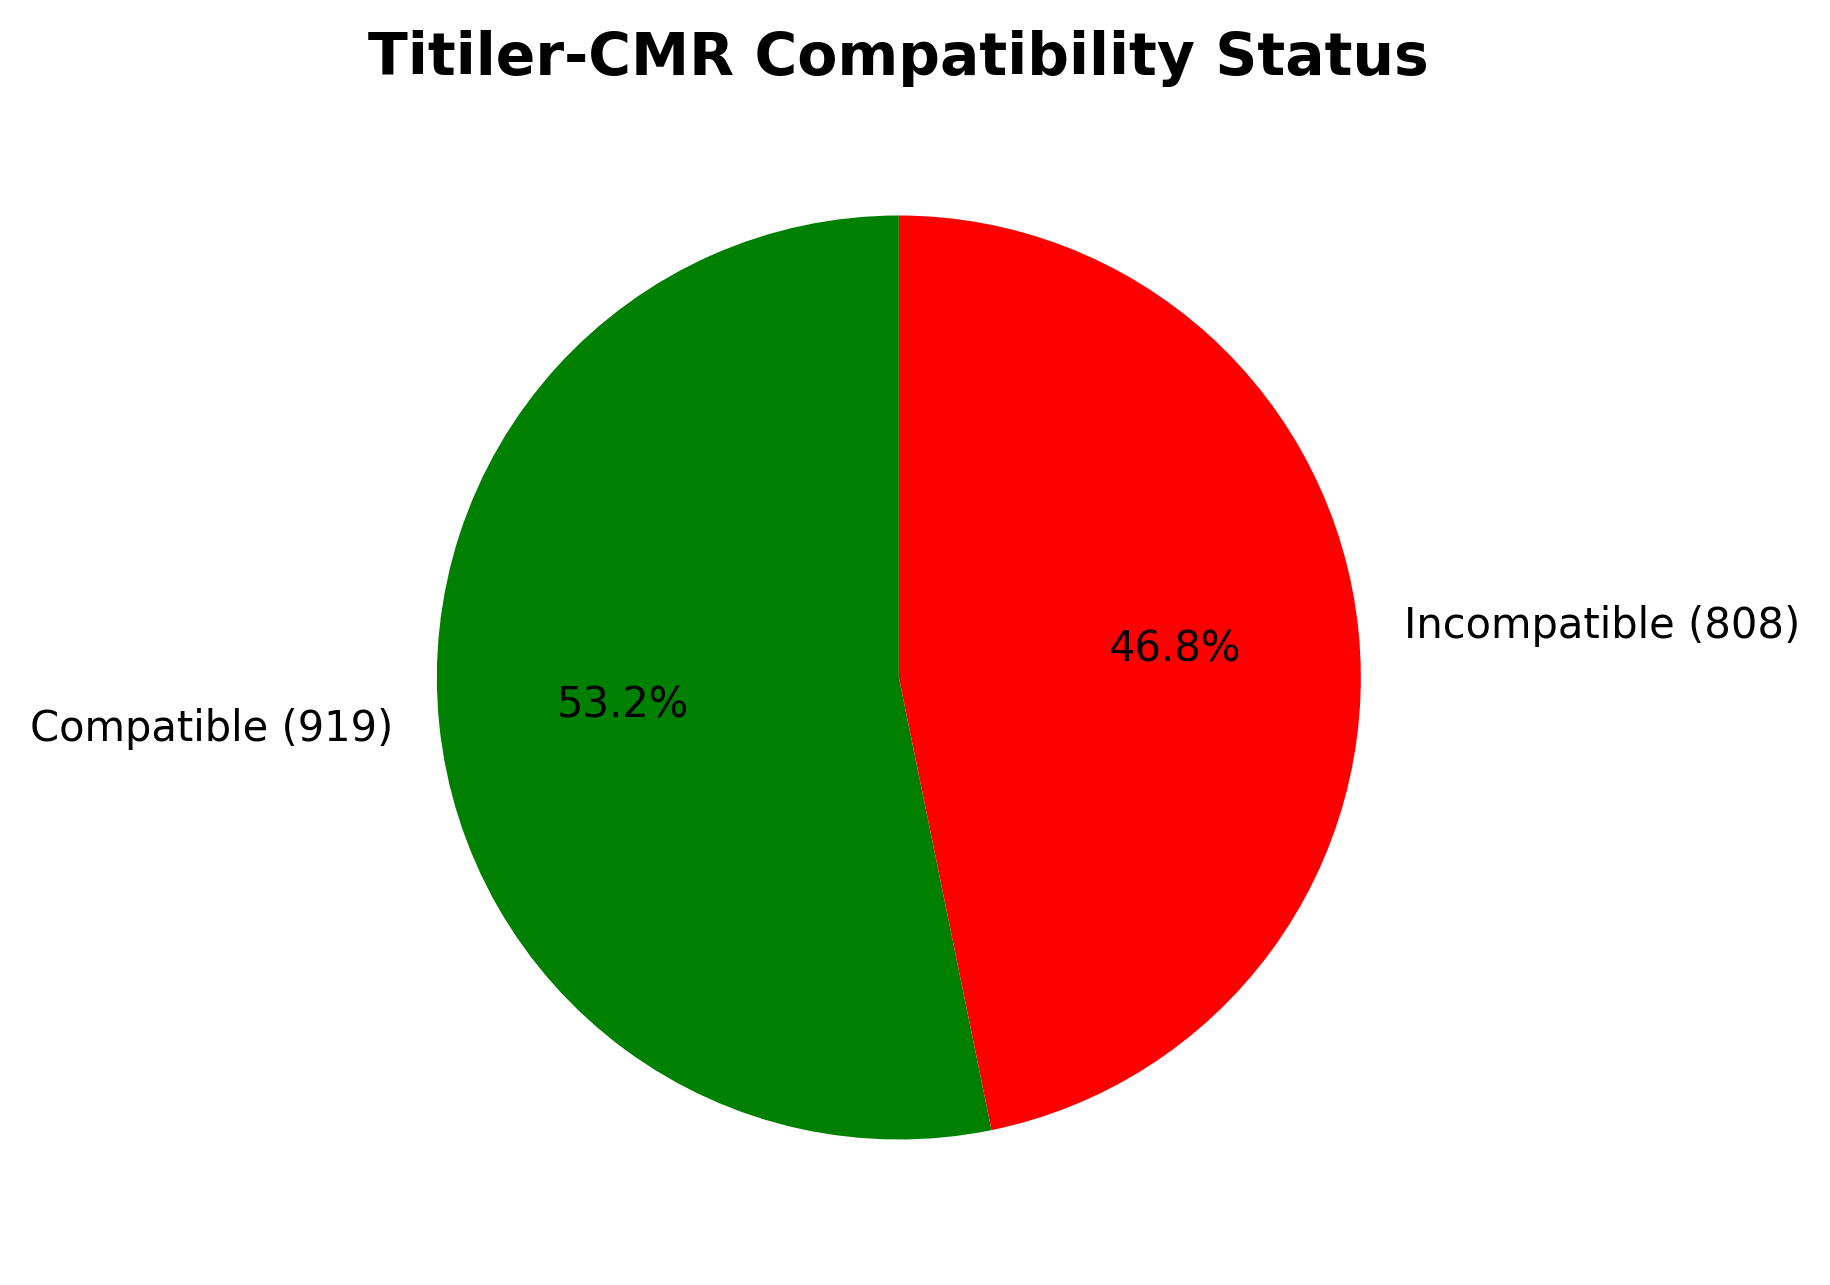


Compatibility Summary:
compatible
True     919
False    808
Name: count, dtype: int64


In [123]:
import matplotlib.pyplot as plt

compatibility_counts = df_read['compatible'].value_counts()

plt.figure(figsize=(5, 5),dpi=300)
labels = [f"{'Compatible' if x else 'Incompatible'} ({compatibility_counts[x]})" 
          for x in compatibility_counts.index]
plt.pie(compatibility_counts.values, 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=['green', 'red'])
plt.title('Titiler-CMR Compatibility Status', fontsize=14, fontweight='bold')
plt.show()

print(f"\nCompatibility Summary:")
print(compatibility_counts)

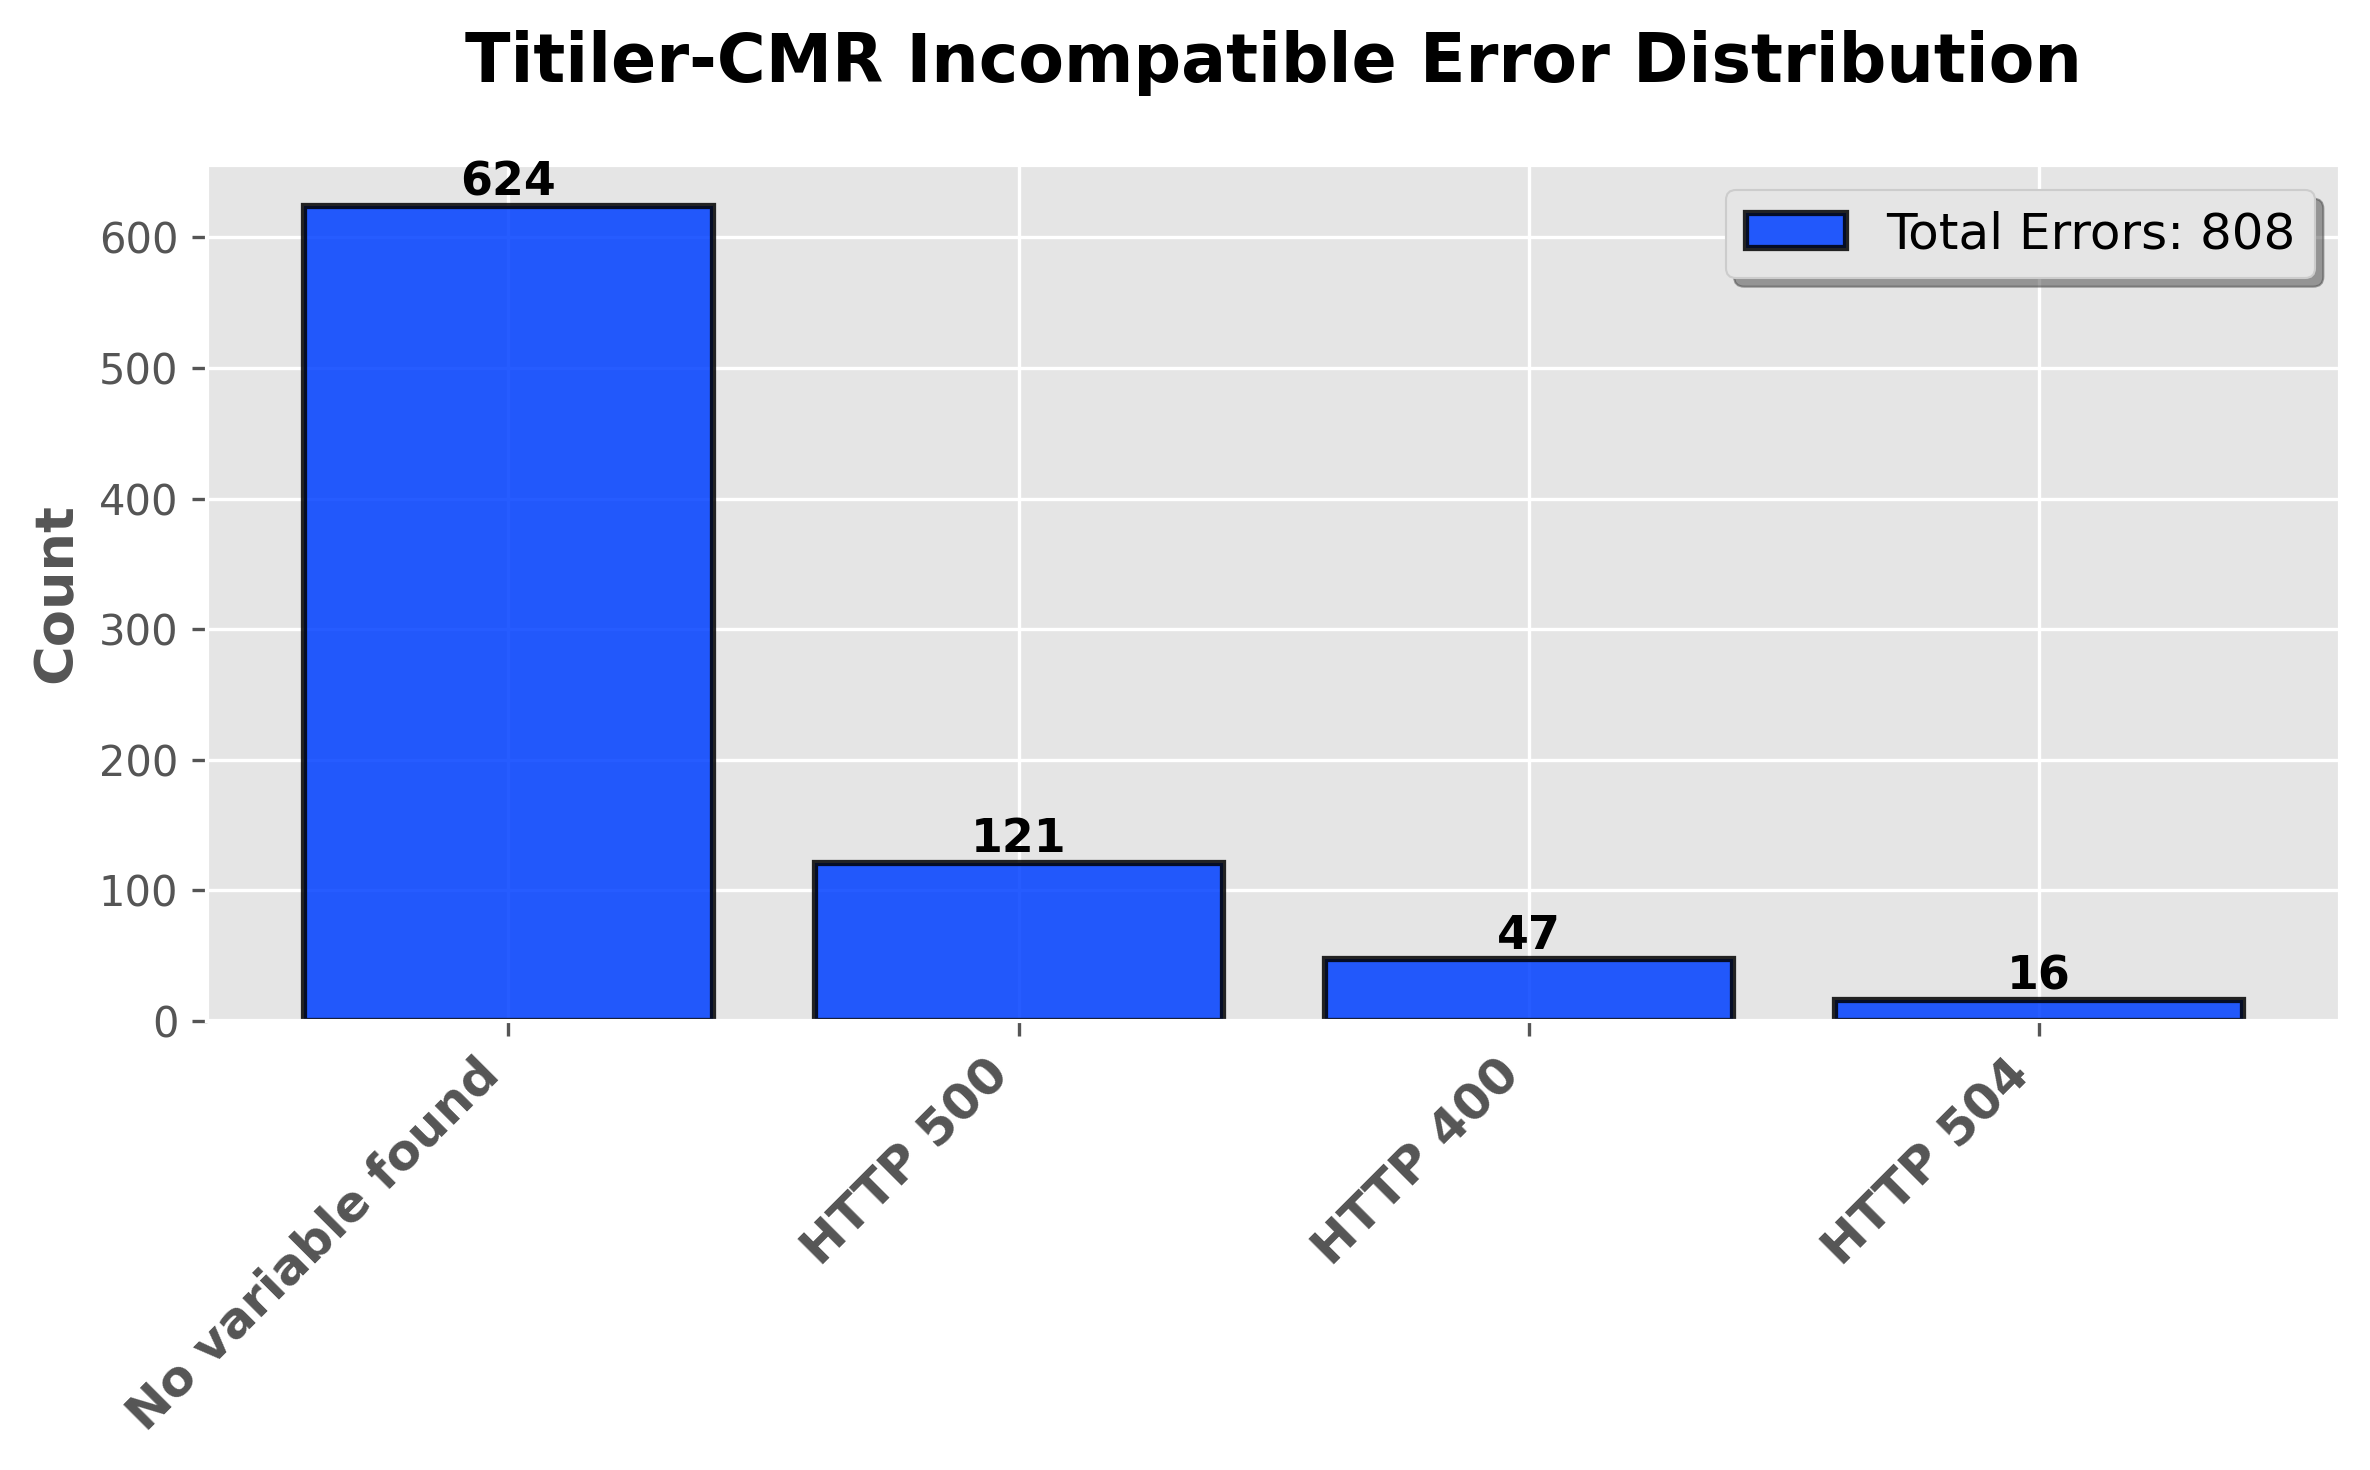


Error Distribution:
status_code
No variable found    624
HTTP 500             121
HTTP 400              47
HTTP 504              16
Name: count, dtype: int64
Total Errors: 808


In [124]:
import matplotlib.pyplot as plt
import pandas as pd
import re

def extract_status_code(error):
    if pd.isna(error) or error is None:
        return None
    match = re.search(r'(?<!\d)([1-5]\d{2})(?!\d)', error)
    if match:
        return f"HTTP {match.group(1)}"
    return error

df_read['status_code'] = df_read['compat_error'].apply(extract_status_code)
error_df = df_read[df_read['status_code'].notna()]
status_counts = error_df['status_code'].value_counts()
total_errors = sum(status_counts.values)

fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

bars = ax.bar(range(len(status_counts)), status_counts.values, 
              edgecolor='black', 
              linewidth=1.5,
              alpha=0.85)

ax.set_xticks(range(len(status_counts)))
ax.set_xticklabels(status_counts.index, rotation=45, ha='right', fontsize=12, fontweight='bold')
ax.set_ylabel('Count', fontsize=13, fontweight='bold')
ax.set_title('Titiler-CMR Incompatible Error Distribution', 
             fontsize=16, fontweight='bold', pad=20)

ax.legend([f'Total Errors: {total_errors}'], 
          loc='upper right', 
          fontsize=12, 
          frameon=True, 
          shadow=True,
          fancybox=True)

for i, (bar, v) in enumerate(zip(bars, status_counts.values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{v}',
            ha='center', va='bottom', 
            fontsize=11, fontweight='bold')



plt.tight_layout()
plt.show()

print("\nError Distribution:")
print(status_counts)
print(f"Total Errors: {total_errors}")

In [111]:
from datetime import datetime

current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = f"compatibility_report_netcdf4_{current_date}.csv"
df_read.to_csv(filename, index=False)
print(f"\nCompatibility report created: {filename}")


Compatibility report created: compatibility_report_netcdf4_2025-10-06_10-04-53.csv
